In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Common imports
import os

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

%matplotlib inline


# Large Margin Classification

So far in the presentation, the difference between the SVC and Logistic Regression classifiers
is in the Loss Function.

The SVC is also able to create a "buffer" on either side of the separating boundary.

By making this buffer as wide as possible, an SVC may generalize better.

The buffer is defined by
- Two additional lines
- Parallel to separating boundary
- Same distance (the *margin*) from the separating boundary


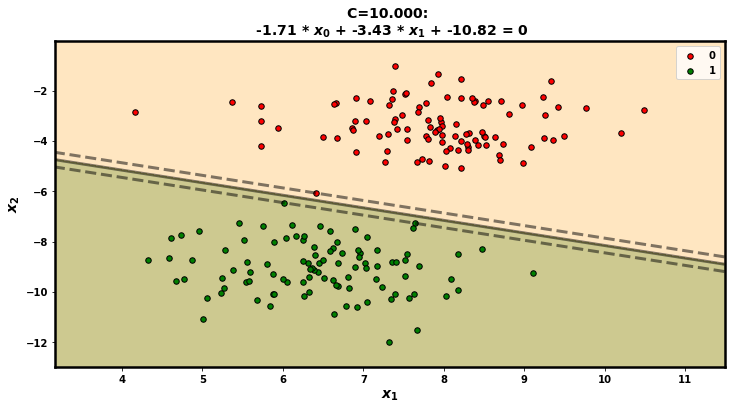

In [4]:
svm_ch = svm_helper.Charts_Helper()
_= svm_ch.create_data()
fig, axs = svm_ch.create_margin(Cs=[10])

- The separating boundary is the solid line, whose equation is given in the title
- Each dashed line
 is
    - Parallel to, and at the same distance from, the separating boundary
    - The distance (measured by length of a line orthogonal to the boundary) from the separating boundary is called the *margin*

The buffer width is twice the margin


In the above plot
- All examples are correctly classified
- There are no examples in the buffer

Requiring these two properties is called *Hard Margin* Classification.

It is somewhat uncommon to be able to achieve the first property (perfect separation of classes).

A more natural Classification task is called *Soft Margin* classification which allows (but penalizes, via the Loss Function)
violation of either property.

We re-run the above example with a larger margin, resulting in the presence of (correctly classified)
examples in the buffer

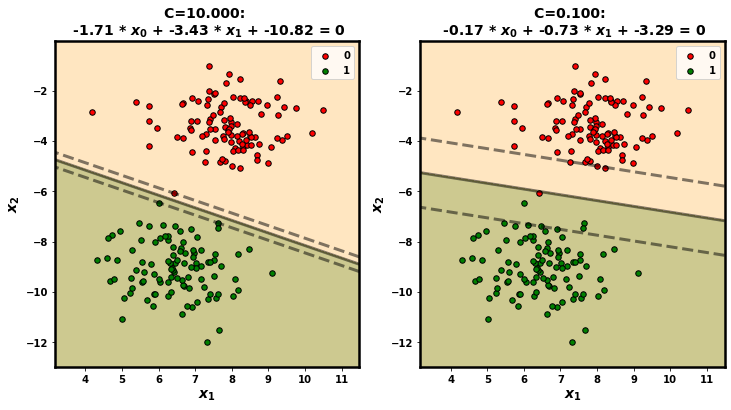

In [5]:
svm_ch = svm_helper.Charts_Helper()
_= svm_ch.create_data()
fig, axs = svm_ch.create_margin(Cs=[10,.1])

We concentrate on Soft Margin Classification going forward.

## Achieving a margin

We need to modify the per-example loss to achieve zero loss
- If the example is correctly classified (i.e., score is on correct side of separating boundary)
- **and** the example is not in the buffer (i.e., score is exceeds the margin)

This can be achieved by moving the "hinge point" of the Hinge Function
- From $0$ to the margin $\margin$

This corresponds to a per-example Loss of 
$$
\loss^\ip = \max{} \left(0,  \margin - \transy^\ip * s(\hat\x) \right)
$$

The above expression achieves zero loss when
$$
    \begin{array}{lll}
     \hat{s}(\x^\ip)  \ge   \margin & \textrm{Positive example},   \transy^\ip = +1  \\
     \hat{s}(\x^\ip)  \le  -\margin & \textrm{Negative example},   \transy^\ip = -1  \\
    \end{array}
$$


As we shall see, a margin $\margin =1$ will suffice resulting in
$$
\loss^\ip = \max{} \left( 0,  1 - \transy^\ip * s(\hat\x \right) 
$$
which we shall encounter repeatedly.

Here's the plot

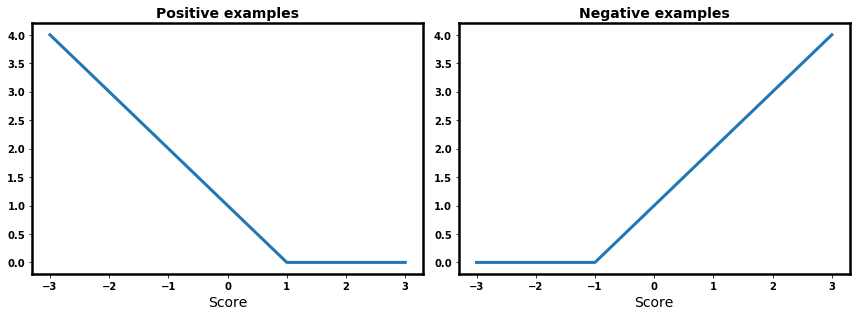

In [6]:
svmh.plot_hinges(hinge_pt=1)

## Achieving a large margin 

As we observed above, a zero loss occurs when
$$
    \begin{array}{lll}
     \hat{s}(\x^\ip)  \ge \margin & \textrm{Positive example},   \transy^\ip = +1  \\
     \hat{s}(\x^\ip)  \le  -\margin & \textrm{Negative example},   \transy^\ip = -1  \\
    \end{array}
$$

Hence, the per-example loss above only imposes a *Classification Loss*
- Penalizing incorrect predictions
- Penalizing correct predictions that are in the buffer

It does not force $\margin$ to be large.

In order to do so, we need to impose a *Margin Penalty*  inversely related to the size of $\margin$.

What would happen if we divided both sides of the inequality by $\margin$ ?
- Zero loss occurs when the inequality's right hand side is $1$
- $\Theta$ would be rescaled by a factor of $\frac{1}{\margin}$

This would result in a large margin $\margin$ being associated with *small* $\Theta$.

We define a Margin Penalty

$$
\frac{1}{2} \Thetam^T \cdot \Thetam
$$

as part of the Loss (that is being minimized) in order to force large $\margin$
- where $\Thetam$ is a minor variation of $\Theta$ as explained below

**Notation**
Our convention is that each example $\x^\ip$ has first feature that is the constant $1$: 
$$\x^\ip = [1, \x^\ip_1, \ldots, \x^\ip_n ]$$
- Design matrix $\X$ has been augmented with a first column of all $1$'s
- This allows us to write $\hat{s}(\x^\ip) = \Theta^T \cdot \x^\ip$
- $\Theta_0$ is the intercept term

Other's (e.g., the Geron book) keep the intercept term *outside* of $\x$
- Resulting in $\hat{s}(\x^\ip) = \Theta^T \cdot \x^\ip + \Theta_0$, where $\x$ *does not* have a leading $1$
- Geron changes notation from previous chapters (in the "Under the Hood" subsection, page 204)

To avoid confusion, we will write $\Thetam$ to be $\Theta$ *excluding* $\Theta_0$
- $\Thetam = \Theta_{1,\cdots}$
- This allows us to write either
    - $\hat{s}(\x^\ip) = \Theta^T \cdot \x^\ip$
    - $\hat{s}(\x^\ip) = \Thetam^T \cdot \x^\ip + \Theta_0$




**Aside**

The mysterious $\frac{1}{2}$ in the Margin Penalty
- Doesn't really affect the overall cost in a significant way
- Will be useful in the mathematical derivations
    - Hint: 
        - $\frac{\partial \Theta^2}{\partial \Theta} = 2 \Theta$
        - The $\frac{1}{2}$ makes the derivative of the Margin Penalty with respect to $\Theta$  exactly $\Theta$
        - The derivative will be used in the optimization of SVM Cost

# SVC Loss Function

The final Average Loss Function for the SVC combines
- Classification Loss per-example (penalize incorrect or in-the-buffer predictions)
- Margin Penalty (penalize small margins)

$$
\loss = \frac{1}{2} \Thetam^T \cdot \Thetam +  C * \frac{1}{m} \sum_{i=1}^m { \max{} \left( 0,  1 - \transy^\ip * s(\hat{\x}^\ip) \right) } 
$$
where
$$
\hat{s}(\x^\ip) = \Theta^T \cdot \x^\ip
$$

- The first term is the Margin Penalty
- The second term is the average of the per-example losses $\loss_i$
    - weighted by a constant $C$

What is $C$ ?
- We have two loss terms: Margin Penalty and Average Classification Loss
- C allows us to express a weight for the relative importance of the two loss terms    

You should recognize this form of loss function (two loss terms, with relative weight)
- It is like a loss function with a Regularization Penalty

In fact, we will provide a mathematical derivation of the Loss that makes this more apparent.

Let's consider extreme cases of $C$:
$$
\begin{array}[lll]\\
C = \infty & \text{No misclassification or buffer violations allowed} \\
C = 0 & \text{Misclassification and buffer violations unimportant}
\end{array}
$$

A high value for $C$
- May prevent a solution
- Encourage overfitting
    - Less importance on forcing elements of $\Theta$ to be zero 
    
A low value for $C$
- Encourages underfitting
    - More importance on forcing elements of $\Theta$ to be zero 

In [7]:
print("Done")

Done
